In [39]:
# Import necessary libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pickle

# Set plot style
plt.style.use('ggplot')

In [40]:
# Load the cleaned financial data
data = pd.read_csv('../data/processed/cleaned_financial_data.csv', index_col='Date', parse_dates=True)

# Extract Tesla's Close prices
tsla_close = data['TSLA']

# Ensure the index is a datetime object
tsla_close.index = pd.to_datetime(tsla_close.index)

# Display the last few rows of the data
print(tsla_close.tail())

Date
2025-01-24    2.478208
2025-01-27    2.397270
2025-01-28    2.405338
2025-01-29    2.328176
2025-01-30    2.424135
Name: TSLA, dtype: float64


In [42]:
# Load the trained ARIMA model
with open('../models/arima_model.pkl', 'rb') as file:
    arima_fit = pickle.load(file)

# Load the trained SARIMA model
with open('../models/sarima_model.pkl', 'rb') as file:
    sarima_fit = pickle.load(file)

# Load the trained LSTM model
lstm_model = load_model('../models/lstm_model.keras')

In [43]:
# Forecast for the next 12 months using ARIMA
forecast_steps = 12 * 21  # Assuming 21 trading days per month

# Generate forecast with confidence intervals
arima_forecast = arima_fit.get_forecast(steps=forecast_steps)

# Extract forecasted values and confidence intervals
arima_mean = arima_forecast.predicted_mean
arima_ci = arima_forecast.conf_int()

# Create a date range for the forecast
forecast_index = pd.date_range(start=tsla_close.index[-1], periods=forecast_steps + 1, freq='B')[1:]

# Combine forecast with historical data
arima_forecast_df = pd.DataFrame({
    'Forecast': arima_mean.values,
    'Lower CI': arima_ci.iloc[:, 0].values,
    'Upper CI': arima_ci.iloc[:, 1].values
}, index=forecast_index)

/home/olana/Desktop/D/KAIM 3/Week 11/Time-Series-Forecasting-Portfolio-Optimization/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/olana/Desktop/D/KAIM 3/Week 11/Time-Series-Forecasting-Portfolio-Optimization/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [44]:
# Forecast for the next 12 months using SARIMA
sarima_forecast = sarima_fit.get_forecast(steps=forecast_steps)

# Extract forecasted values and confidence intervals
sarima_mean = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()

# Combine forecast with historical data
sarima_forecast_df = pd.DataFrame({
    'Forecast': sarima_mean.values,
    'Lower CI': sarima_ci.iloc[:, 0].values,
    'Upper CI': sarima_ci.iloc[:, 1].values
}, index=forecast_index)

/home/olana/Desktop/D/KAIM 3/Week 11/Time-Series-Forecasting-Portfolio-Optimization/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [45]:
# Preprocess data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(tsla_close).reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 30
X_test, _ = create_sequences(scaled_data, seq_length)
X_test = X_test[-1].reshape(1, seq_length, 1)  # Use the last sequence for forecasting

# Forecast for the next 12 months using LSTM
lstm_forecast = []
for _ in range(forecast_steps):
    next_price = lstm_model.predict(X_test)[0][0]
    lstm_forecast.append(next_price)
    next_price_reshaped = np.array([[next_price]]).reshape(1, 1, 1)
    X_test = np.concatenate([X_test[:, 1:, :], next_price_reshaped], axis=1)

# Inverse transform the forecast
lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast).reshape(-1, 1)).flatten()

# Combine forecast with historical data
lstm_forecast_df = pd.DataFrame({'Forecast': lstm_forecast}, index=forecast_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━

Forecasted Prices:
               ARIMA    SARIMA      LSTM
2025-01-31  0.221285  0.223946  2.340336
2025-02-03  0.217512  0.206064  2.323132
2025-02-04  0.224997  0.198107  2.315359
2025-02-05  0.229280  0.188579  2.313770
2025-02-06  0.231622  0.165307  2.316329


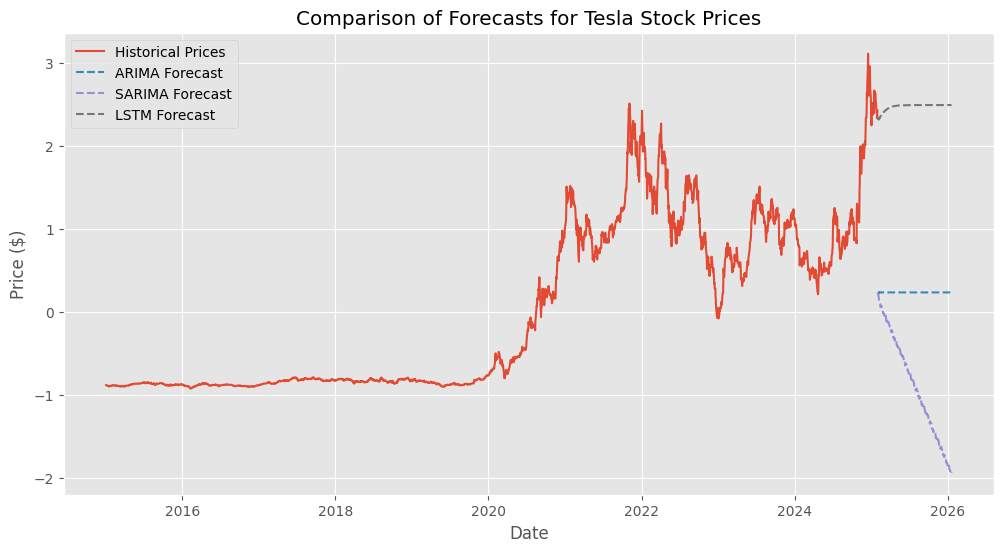

In [46]:
# Combine all forecasts into one DataFrame
forecasts = pd.concat([arima_forecast_df['Forecast'], sarima_forecast_df['Forecast'], lstm_forecast_df], axis=1)
forecasts.columns = ['ARIMA', 'SARIMA', 'LSTM']

# Display the forecasted data
print("Forecasted Prices:")
print(forecasts.head())

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(tsla_close, label='Historical Prices')
plt.plot(forecasts['ARIMA'], label='ARIMA Forecast', linestyle='--')
plt.plot(forecasts['SARIMA'], label='SARIMA Forecast', linestyle='--')
plt.plot(forecasts['LSTM'], label='LSTM Forecast', linestyle='--')
plt.title('Comparison of Forecasts for Tesla Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

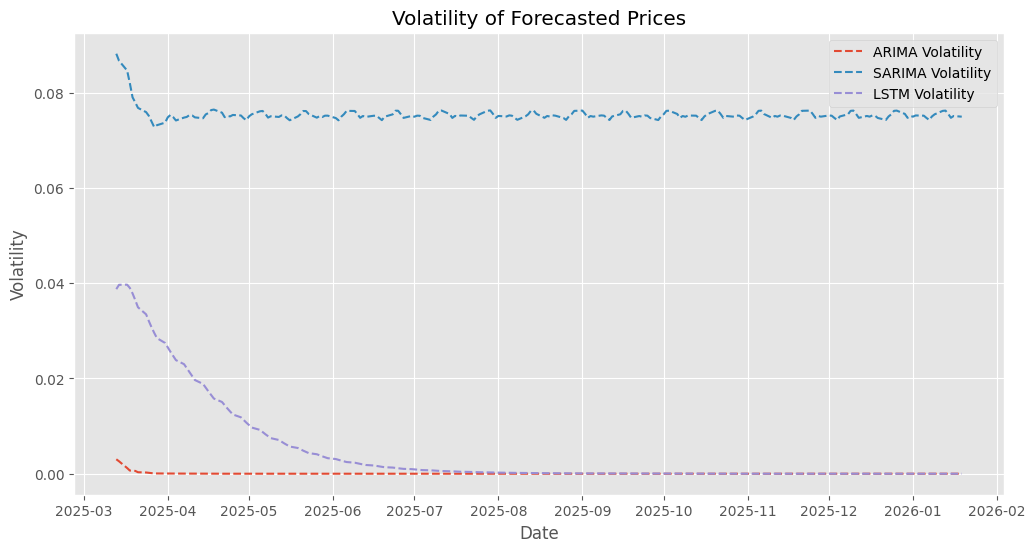

In [47]:
# Calculate rolling standard deviation for the forecast
rolling_std = forecasts.rolling(window=30).std()

# Plot volatility
plt.figure(figsize=(12, 6))
for model in forecasts.columns:
    plt.plot(rolling_std[model], label=f'{model} Volatility', linestyle='--')
plt.title('Volatility of Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [48]:
# Save the forecasted data to a CSV file
forecasts.to_csv('../results/tesla_forecast.csv')

print("Forecasted data saved to 'results/tesla_forecast.csv'.")

Forecasted data saved to 'results/tesla_forecast.csv'.
